<a href="https://colab.research.google.com/github/WeiShaoD/Deep_learning/blob/main/tutorials/W1D5_Optimization/student/W1D5_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Optimization techniques

**Week 1, Day 5: Optimization**

**By Neuromatch Academy**

__Content creators:__ Jose Gallego-Posada, Ioannis Mitliagkas

__Content reviewers:__ Piyush Chauhan, Vladimir Haltakov, Siwei Bai, Kelson Shilling-Scrivo

__Content editors:__ Charles J Edelson, Gagana B, Spiros Chavlis

__Production editors:__ Arush Tagade, R. Krishnakumaran, Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

Objectives:
*   Necessity and importance of optimization
*   Introduction to commonly used optimization techniques
*   Optimization in non-convex loss landscapes 
*   'Adaptive' hyperparameter tuning 
*   Ethical concerns



In [1]:
# @title Tutorial slides

from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/ft2sz/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

These are the slides for all videos in this tutorial. If you want to locally download the slides, click [here](https://osf.io/ft2sz/download).

---
# Setup

In [2]:
# @title Install dependencies
!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG', 'W1D5_T1','https://portal.neuromatchacademy.org/api/redirect/to/2c5bbb85-d91a-4f5a-99fa-cefc287653d7')

In [3]:
# Imports
import copy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

import time
import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

In [4]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
plt.rc('axes', unicode_minus=False)

In [5]:
# @title Helper functions
def print_params(model):
  """
  Lists the name and current value of the model's
  named parameters

  Args:
    model: an nn.Module inherited model
      Represents the ML/DL model

  Returns:
    Nothing
  """
  for name, param in model.named_parameters():
    if param.requires_grad:
      print(name, param.data)

In [6]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call the `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Handles variability by controlling sources of randomness
  through set seed values

  Args:
    seed: Integer
      Set the seed value to given integer.
      If no seed, set seed value to random integer in the range 2^32
    seed_torch: Bool
      Seeds the random number generator for all devices to
      offer some guarantees on reproducibility

  Returns:
    Nothing
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules are used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.


---
# Section 1. Introduction

*Time estimate: ~15 mins*

In [9]:
# @title Video 1: Introduction
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1VB4y1K7Vr", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"zm9oekdkJbQ", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Introduction')

display(out)

## Discuss: Unexpected consequences

Can you think of examples from your own experience/life where poorly chosen incentives or objectives have led to unexpected consequences?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_1ecffd5a.py)



---
# Section 2: Case study: successfully training an MLP for image classification

*Time estimate: ~40 mins*

Many of the core ideas (and tricks) in modern optimization for deep learning can be illustrated in the simple setting of training an MLP to solve an image classification task. In this tutorial we will guide you through the key challenges that arise when optimizing high-dimensional, non-convex$^\dagger$ problems. We will use these challenges to motivate and explain some commonly used solutions.

**Disclaimer:** Some of the functions you will code in this tutorial are already implemented in Pytorch and many other libraries. For pedagogical reasons, we decided to bring these simple coding tasks into the spotlight and place a relatively higher emphasis in your understanding of the algorithms, rather than the use of a specific library. 

In 'day-to-day' research projects you will likely rely on the community-vetted, optimized libraries rather than the 'manual implementations' you will write today. In Section 8 you will have a chance to 'put it all together' and use the full power of Pytorch to tune the parameters of an MLP to classify handwritten digits.

$^\dagger$: A **strictly convex** function has the same global and local minimum - a nice property for optimization as it won't get stuck in a local minimum that isn't a global one (e.g., $f(x)=x^2 + 2x + 1$). A **non-convex** function is wavy - has some 'valleys' (local minima) that aren't as deep as the overall deepest 'valley' (global minimum). Thus, the optimization algorithms can get stuck in the local minimum, and it can be hard to tell when this happens (e.g., $f(x) = x^4 + x^3 - 2x^2 - 2x$). See also **Section 5** for more details.

In [10]:
# @title Video 2: Case Study - MLP Classification
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1GB4y1K7Ha", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"pJc2ENhYbqA", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Case Study - MLP Classification')

display(out)

## Section 2.1: Data

We will use the MNIST dataset of handwritten digits. We load the data via the Pytorch `datasets` module, as you learned in W1D1.

**Note:** Although we can download the MNIST dataset directly from `datasets` using the optional argument `download=True`, we are going to download them from NMA directory on OSF to ensure network reliability.


In [11]:
# @title Download MNIST dataset
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'MNIST'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed.')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall()
    os.remove(fname)
else:
  print('MNIST dataset has been downloaded.')

In [12]:
def load_mnist_data(change_tensors=False, download=False):
  """
  Load training and test examples for the MNIST handwritten digits dataset
  with every image: 28*28 x 1 channel (greyscale image)

  Args:
    change_tensors: Bool
      Argument to check if tensors need to be normalised
    download: Bool
      Argument to check if dataset needs to be downloaded/already exists

  Returns:
    train_set:
      train_data: Tensor
        training input tensor of size (train_size x 784)
      train_target: Tensor
        training 0-9 integer label tensor of size (train_size)
    test_set:
      test_data: Tensor
        test input tensor of size (test_size x 784)
      test_target: Tensor
        training 0-9 integer label tensor of size (test_size)
  """
  # Load train and test sets
  train_set = datasets.MNIST(root='.', train=True, download=download,
                             transform=torchvision.transforms.ToTensor())
  test_set = datasets.MNIST(root='.', train=False, download=download,
                            transform=torchvision.transforms.ToTensor())

  # Original data is in range [0, 255]. We normalize the data wrt its mean and std_dev.
  # Note that we only used *training set* information to compute mean and std
  mean = train_set.data.float().mean()
  std = train_set.data.float().std()

  if change_tensors:
    # Apply normalization directly to the tensors containing the dataset
    train_set.data = (train_set.data.float() - mean) / std
    test_set.data = (test_set.data.float() - mean) / std
  else:
    tform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean=[mean / 255.], std=[std / 255.])
                                            ])
    train_set = datasets.MNIST(root='.', train=True, download=download,
                               transform=tform)
    test_set = datasets.MNIST(root='.', train=False, download=download,
                              transform=tform)

  return train_set, test_set


train_set, test_set = load_mnist_data(change_tensors=True)

As we are just getting started, we will concentrate on a small subset of only 500 examples out of the 60.000 data points contained in the whole training set.



In [13]:
# Sample a random subset of 500 indices
subset_index = np.random.choice(len(train_set.data), 500)

# We will use these symbols to represent the training data and labels, to stay
# as close to the mathematical expressions as possible.
X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

Run the following cell to visualize the content of three examples in our training set. Note how the preprocessing we applied to the data changes the range of pixel values after normalization.


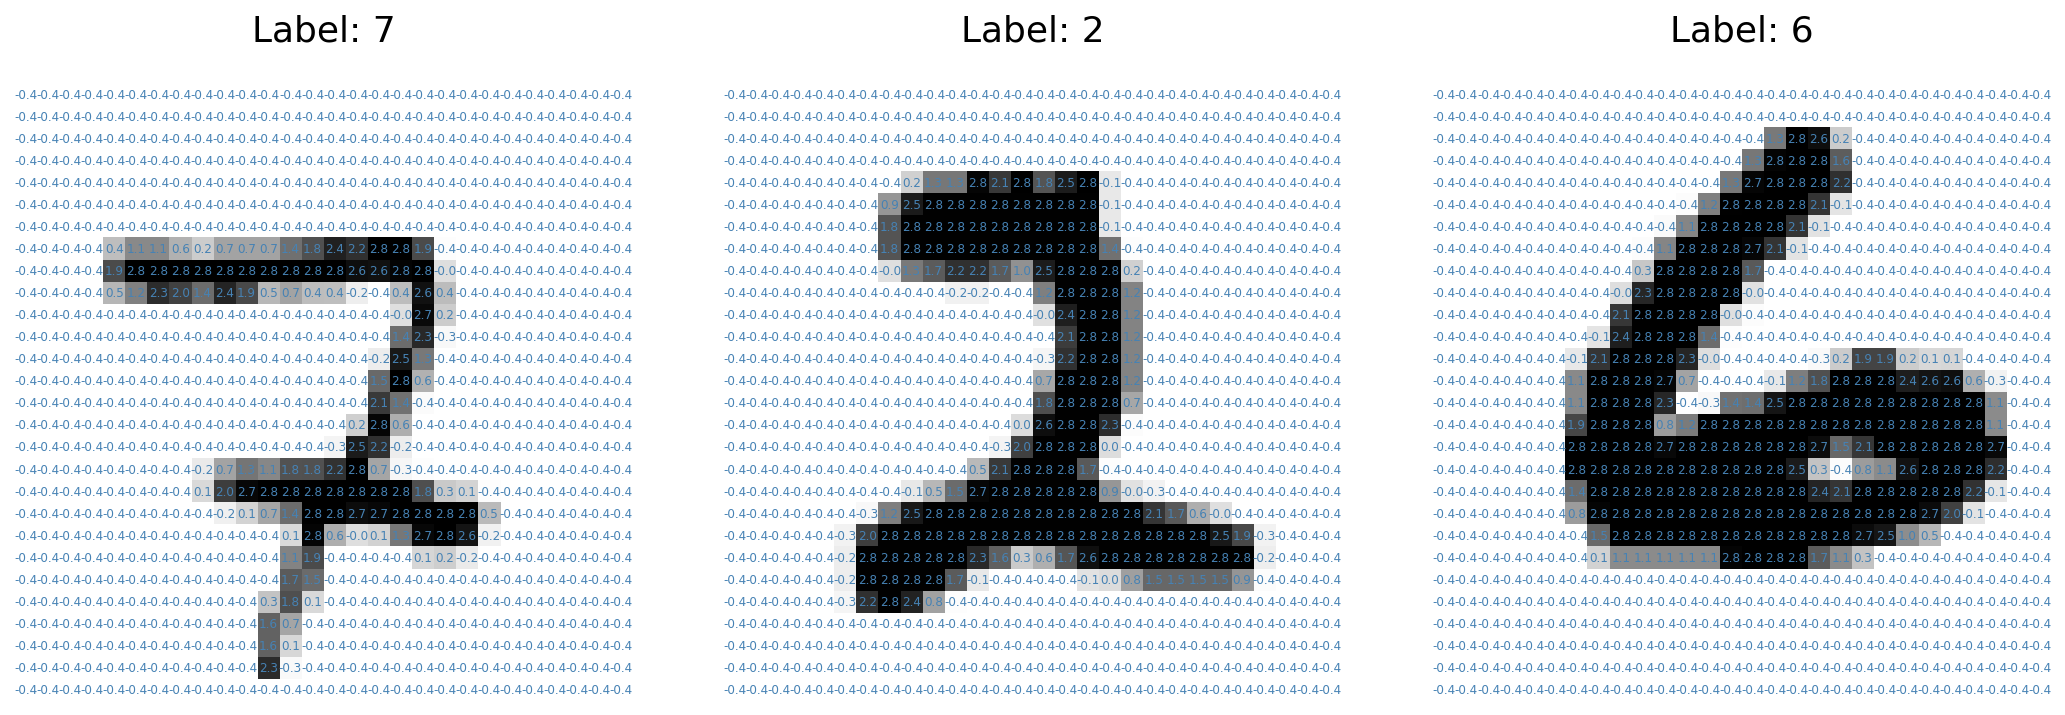

In [14]:
# @title Run me!

# Exploratory data analysis and visualisation

num_figures = 3
fig, axs = plt.subplots(1, num_figures, figsize=(5 * num_figures, 5))

for sample_id, ax in enumerate(axs):
  # Plot the pixel values for each image
  ax.matshow(X[sample_id, :], cmap='gray_r')
  # 'Write' the pixel value in the corresponding location
  for (i, j), z in np.ndenumerate(X[sample_id, :]):
    text = '{:.1f}'.format(z)
    ax.text(j, i, text, ha='center',
            va='center', fontsize=6, c='steelblue')

  ax.set_title('Label: ' + str(y[sample_id].item()))
  ax.axis('off')

plt.show()

## Section 2.2: Model

As you will see next week, there are specific model architectures that are better suited to image-like data, such as Convolutional Neural Networks (CNNs). For simplicity, in this tutorial we will focus exclusively on Multi-Layer Perceptron (MLP) models as they allow us to highlight many important optimization challenges shared with more advanced neural network designs.

In [15]:
class MLP(nn.Module):
  """
  This class implements MLPs in Pytorch of an arbitrary number of hidden
  layers of potentially different sizes. Since we concentrate on classification
  tasks in this tutorial, we have a log_softmax layer at prediction time.
  """

  def __init__(self, in_dim=784, out_dim=10, hidden_dims=[], use_bias=True):
    """
    Constructs a MultiLayerPerceptron

    Args:
      in_dim: Integer
        dimensionality of input data (784)
      out_dim: Integer
        number of classes (10)
      hidden_dims: List
        containing the dimensions of the hidden layers,
        empty list corresponds to a linear model (in_dim, out_dim)

    Returns:
      Nothing
    """

    super(MLP, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    # If we have no hidden layer, just initialize a linear model (e.g. in logistic regression)
    if len(hidden_dims) == 0:
      layers = [nn.Linear(in_dim, out_dim, bias=use_bias)]
    else:
      # 'Actual' MLP with dimensions in_dim - num_hidden_layers*[hidden_dim] - out_dim
      layers = [nn.Linear(in_dim, hidden_dims[0], bias=use_bias), nn.ReLU()]

      # Loop until before the last layer
      for i, hidden_dim in enumerate(hidden_dims[:-1]):
        layers += [nn.Linear(hidden_dim, hidden_dims[i + 1], bias=use_bias),
                   nn.ReLU()]

      # Add final layer to the number of classes
      layers += [nn.Linear(hidden_dims[-1], out_dim, bias=use_bias)]

    self.main = nn.Sequential(*layers)

  def forward(self, x):
    """
    Defines the network structure and flow from input to output

    Args:
      x: Tensor
        Image to be processed by the network

    Returns:
      output: Tensor
        same dimension and shape as the input with probabilistic values in the range [0, 1]

    """
    # Flatten each images into a 'vector'
    transformed_x = x.view(-1, self.in_dim)
    hidden_output = self.main(transformed_x)
    output = F.log_softmax(hidden_output, dim=1)
    return output

Linear models constitute a very special kind of MLPs: they are equivalent to an MLP with *zero* hidden layers. This is simply an affine transformation, in other words a 'linear' map $W x$ with an 'offset' $b$; followed by a softmax function.

$$f(x) = \text{softmax}(W x + b)$$

Here $x \in \mathbb{R}^{784}$, $W \in \mathbb{R}^{10 \times 784}$ and $b \in \mathbb{R}^{10}$. Notice that the dimensions of the weight matrix are $10 \times 784$ as the input tensors are flattened images, i.e., $28 \times 28 = 784$-dimensional tensors and the output layer consists of $10$ nodes. Also, note that the implementation of softmax encapsulates b in W i.e., It maps the rows of the input instead of the columns. That is, the i’th row of the output is the mapping of the i’th row of the input under W, plus the bias term. Refer Affine maps here: https://pytorch.org/tutorials/beginner/nlp/deep_learning_tutorial.html#affine-maps

In [16]:
# Empty hidden_dims means we take a model with zero hidden layers.
model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

# We print the model structure with 784 inputs and 10 outputs
print(model)

MLP(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


## Section 2.3: Loss

While we care about the accuracy of the model, the 'discrete' nature of the 0-1 loss makes it challenging to optimize. In order to learn good parameters for this model, we will use the cross entropy loss (negative log-likelihood), which you saw in the last lecture, as a surrogate objective to be minimized. 

This particular choice of model and optimization objective leads to a *convex* optimization problem with respect to the parameters $W$ and $b$. 

In [17]:
loss_fn = F.nll_loss

## Section 2.4: Interpretability

In the last lecture, you saw that inspecting the weights of a model can provide insights on what 'concepts' the model has learned. Here we show the weights of a partially trained model. The weights corresponding to each class 'learn' to _fire_ when an input of the class is detected.


In [18]:
#@markdown Run _this cell_ to train the model. If you are curious about how the training
#@markdown takes place, double-click this cell to find out. At the end of this tutorial
#@markdown you will have the opportunity to train a more complex model on your own.

cell_verbose = False
partial_trained_model = MLP(in_dim=784, out_dim=10, hidden_dims=[])

if cell_verbose:
  print('Init loss', loss_fn(partial_trained_model(X), y).item()) # This matches around np.log(10 = # of classes)

# Invoke an optimizer using Adaptive gradient and Momentum (more about this in Section 7)
optimizer = optim.Adam(partial_trained_model.parameters(), lr=7e-4)
for _ in range(200):
  loss = loss_fn(partial_trained_model(X), y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

if cell_verbose:
  print('End loss', loss_fn(partial_trained_model(X), y).item()) # This should be less than 1e-2

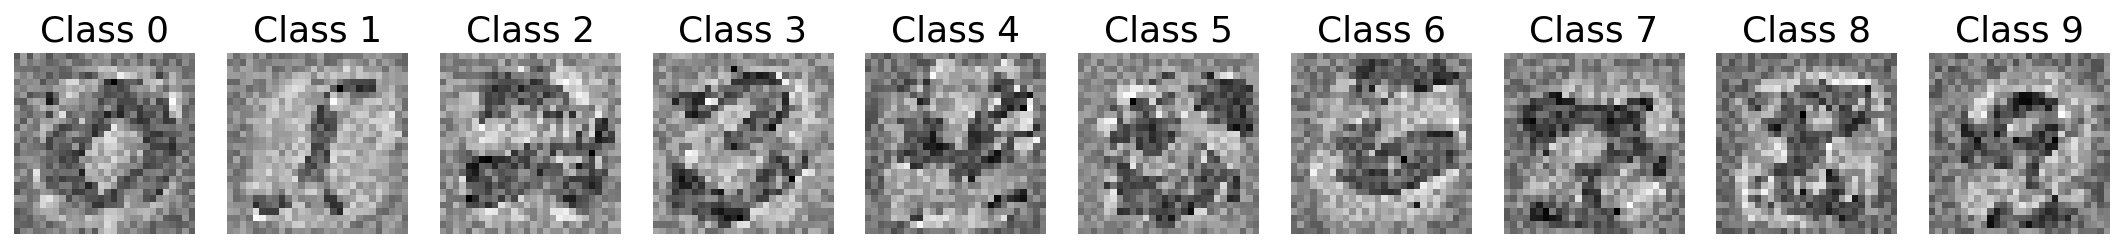

In [19]:
# Show class filters of a trained model
W = partial_trained_model.main[0].weight.data.numpy()

fig, axs = plt.subplots(1, 10, figsize=(15, 4))
for class_id in range(10):
  axs[class_id].imshow(W[class_id, :].reshape(28, 28), cmap='gray_r')
  axs[class_id].axis('off')
  axs[class_id].set_title('Class ' + str(class_id) )

plt.show()

---
# Section 3: High dimensional search

*Time estimate: ~25 mins*

We now have a model with its corresponding trainable parameters as well as an objective to optimize. Where do we goto next? How do we find a 'good' configuration of parameters?

One idea is to choose a random direction and move only if the objective is reduced. However, this is inefficient in high dimensions and you will see how gradient descent (with a suitable step-size) can guarantee consistent improvement in terms of the objective function.

In [20]:
# @title Video 3: Optimization of an Objective Function
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1aL411H7Ce", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"aSJTRdjRvvw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Optimization of an Objective Function')

display(out)

## Coding Exercise 3: Implement gradient descent

In this exercise you will use PyTorch automatic differentiation capabilities to compute the gradient of the loss with respect to the parameters of the model. You will then use these gradients to implement the update performed by the gradient descent method.  

In [21]:
def zero_grad(params):
  """
  Clear gradients as they accumulate on successive backward calls

  Args:
    params: an iterator over tensors
      i.e., updating the Weights and biases

  Returns:
    Nothing
  """
  for par in params:
    if not(par.grad is None):
      par.grad.data.zero_()


def random_update(model, noise_scale=0.1, normalized=False):
  """
  Performs a random update on the parameters of the model to help
  understand the effectiveness of updating random directions
  for the problem of optimizing the parameters of a high-dimensional linear model.

  Args:
    model: nn.Module derived class
      The model whose parameters are to be updated

    noise_scale: float
      Specifies the magnitude of random weight

    normalized: Bool
      Indicates if the parameter has been normalised or not

  Returns:
    Nothing
  """
  for par in model.parameters():
    noise = torch.randn_like(par)
    if normalized:
      noise /= torch.norm(noise)
    par.data +=  noise_scale * noise

In [22]:
def gradient_update(loss, params, lr=1e-3):
  """
  Perform a gradient descent update on a given loss over a collection of parameters

  Args:
    loss: Tensor
      A scalar tensor containing the loss through which the gradient will be computed
    params: List of iterables
      Collection of parameters with respect to which we compute gradients
    lr: Float
      Scalar specifying the learning rate or step-size for the update

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)

  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for par in params:
      #################################################
      ## TODO for students: update the value of the parameter ##
      #raise NotImplementedError("Student exercise: implement gradient update")
      #################################################
      # Here we work with the 'data' attribute of the parameter rather than the
      # parameter itself.
      # Hence - use the learning rate and the parameter's .grad.data attribute to perform an update
      par.data -= lr * par.grad.data


# add event to airtable
atform.add_event('Coding Exercise 3: Implement gradient descent')


set_seed(seed=SEED)
model1 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model1 parameters before the update are: \n')
print_params(model1)
loss = loss_fn(model1(X), y)

## Uncomment below to test your function
gradient_update(loss, list(model1.parameters()), lr=1e-1)
print('\n The model1 parameters after the update are: \n')
print_params(model1)

Random seed 2021 has been set.

 The model1 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model1 parameters after the update are: 

main.0.weight tensor([[-0.0263,  0.0010,  0.0174,  ...,  0.0298,  0.0278, -0.0220],
        [-0.0047, -0.0302, -0.0093,  ..., -0.0077,  0.0248, -0.0240],
        [ 0.0234, -0.0237,  0.0335,  ...,  0.0117,  0.0263, -0.0187],
        ...,
        [-0.0006,  0.0156,  0.0110,  ...,  0.0143, -0.0302, -0.0145]

```
 The model1 parameters after the update are: 

main.0.weight tensor([[-0.0263,  0.0010,  0.0174,  ...,  0.0298,  0.0278, -0.0220],
        [-0.0047, -0.0302, -0.0093,  ..., -0.0077,  0.0248, -0.0240],
        [ 0.0234, -0.0237,  0.0335,  ...,  0.0117,  0.0263, -0.0187],
        ...,
        [-0.0006,  0.0156,  0.0110,  ...,  0.0143, -0.0302, -0.0145],
        [ 0.0164,  0.0286,  0.0238,  ..., -0.0127, -0.0191,  0.0188],
        [ 0.0206, -0.0354, -0.0184,  ..., -0.0272,  0.0098,  0.0002]])
main.0.bias tensor([-0.0292, -0.0018,  0.0115, -0.0370,  0.0054,  0.0155,  0.0317,  0.0246,
         0.0198, -0.0061])
```

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_63933ab2.py)



## Comparing updates

These plots compare the effectiveness of updating random directions for the problem of optimizing the parameters of a high-dimensional linear model. We contrast the behavior at initialization and during an intermediate stage of training by showing the histograms of change in loss over 100 different random directions vs the change in loss induced by the gradient descent update

**Remember:** Since we are trying to minimize here, the more negative the better!


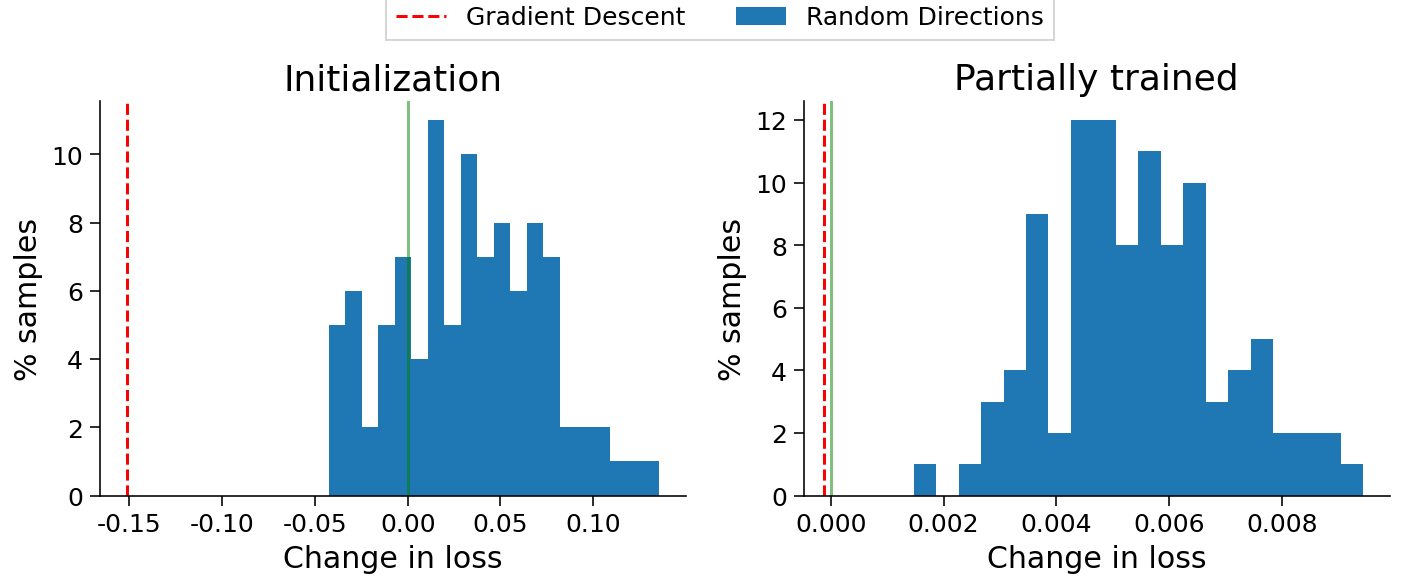

In [23]:
# @markdown _Run this cell_ to visualize the results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for id, (model_name, my_model) in enumerate([('Initialization', model),
                                              ('Partially trained', partial_trained_model)]):
  # Compute the loss we will be comparing to
  base_loss = loss_fn(my_model(X), y)

  # Compute the improvement via gradient descent
  dummy_model = copy.deepcopy(my_model)
  loss1 = loss_fn(dummy_model(X), y)
  gradient_update(loss1, list(dummy_model.parameters()), lr=1e-2)
  gd_delta = loss_fn(dummy_model(X), y) - base_loss

  deltas = []
  for trial_id in range(100):
    # Compute the improvement obtained with a random direction
    dummy_model = copy.deepcopy(my_model)
    random_update(dummy_model, noise_scale=1e-2)
    deltas.append((loss_fn(dummy_model(X), y) - base_loss).item())

  # Plot histogram for random direction and vertical line for gradient descent
  axs[id].hist(deltas, label='Random Directions', bins=20)
  axs[id].set_title(model_name)
  axs[id].set_xlabel('Change in loss')
  axs[id].set_ylabel('% samples')
  axs[id].axvline(0, c='green', alpha=0.5)
  axs[id].axvline(gd_delta.item(), linestyle='--', c='red', alpha=1,
                  label='Gradient Descent')


handles, labels = axs[id].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 1.05),
           fancybox=False, shadow=False, ncol=2)

plt.show()

## Think! 3: Gradient descent vs. random search

Compare the behavior of gradient descent and random search based on the histograms above. Is any of the two methods more reliable? How can you explain the changes between behavior of the methods at initialization vs during training?

In [24]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_c2013acf.py)



---
# Section 4: Poor conditioning

*Time estimate: ~30 mins*

Already in this 'simple' logistic regression problem, the issue of bad conditioning is haunting us. Not all parameters are created equal and the sensitivity of the network to changes on the parameters will have a big impact in the dynamics of the optimization.


In [25]:
# @title Video 4: Momentum
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1NL411H71t", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"3ES5O58Y_2M", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Momentum')

display(out)

We illustrate this issue in a 2-dimensional setting. We freeze all but two parameters of the network: one of them is an element of the weight matrix (filter) for class 0, while the other is the bias for class 7. This results in an optimization with two decision variables.

How much difference is there in the behavior of these two parameters under gradient descent? What is the effect of momentum in bridging that gap?


In [26]:
# to remove solution
"""
The landscapes of the two parameters appear to be
flatter under gradient descent as can be seen in interactive demo 4 below.

As randomly-initialised models exhibit chaos, we use the Newton's approach
by tweaking the learning rate i.e., taking smaller steps in the indicated
direction and recomputing gradients to find an optimal solution on a
varied surface. Momentum helps reduce the chaos by maintaining a consistent
direction for exploration (linear combination of the previous heading vector,
and the newly-computed gradient vector).
""";

In [27]:
# @markdown _Run this cell_ to setup some helper functions.

def loss_2d(model, u, v, mask_idx=(0, 378), bias_id=7):
  """
  Defines a 2-dim function by freezing all
  but two parameters of a linear model.

  Args:
    model: nn.Module
      a pytorch linear model
    u: Scalar
      first free parameter
    u: Scalar
      second free parameter
    mask_idx: Tuple
      selects parameter in weight matrix replaced by u
    bias_idx: Integer
      selects parameter in bias vector replaced by v

  Returns:
    loss: Scalar
      loss of the 'new' model
      over inputs X, y (defined externally)
  """

  # We zero out the element of the weight tensor that will be
  # replaced by u
  mask = torch.ones_like(model.main[0].weight)
  mask[mask_idx[0], mask_idx[1]] = 0.
  masked_weights = model.main[0].weight * mask

  # u is replacing an element of the weight matrix
  masked_weights[mask_idx[0], mask_idx[1]] = u

  res = X.reshape(-1, 784) @ masked_weights.T + model.main[0].bias

  # v is replacing a bias for class 7
  res[:, 7] += v - model.main[0].bias[7]
  res =  F.log_softmax(res, dim=1)

  return loss_fn(res, y)


def plot_surface(U, V, Z, fig):
  """
  Plot a 3D loss surface given
  meshed inputs U, V and values Z

  Args:
    U: nd.array()
      Input to plot for obtaining 3D loss surface
    V: nd.array()
      Input to plot for obtaining 3D loss surface
    Z: nd.array()
      Input to plot for obtaining 3D loss surface
    fig: matplotlib.figure.Figure instance
      Helps create a new figure, or activate an existing figure.

  Returns:
    ax: matplotlib.axes._subplots.AxesSubplot instance
      Plotted subplot data
  """
  ax = fig.add_subplot(1, 2, 2, projection='3d')
  ax.view_init(45, -130)

  surf = ax.plot_surface(U, V, Z, cmap=plt.cm.coolwarm,
                      linewidth=0, antialiased=True, alpha=0.5)

  # Select certain level contours to plot
  # levels = Z.min() * np.array([1.005, 1.1, 1.3, 1.5, 2.])
  # plt.contour(U, V, Z)# levels=levels, alpha=0.5)

  ax.set_xlabel('Weight')
  ax.set_ylabel('Bias')
  ax.set_zlabel('Loss', rotation=90)

  return ax


def plot_param_distance(best_u, best_v, trajs, fig, styles, labels,
                        use_log=False, y_min_v=-12.0, y_max_v=1.5):
  """
  Plot the distance to each of the
  two parameters for a collection of 'trajectories'

  Args:
    best_u: float
      Optimal distance of vector u within trajectory
    best_v: float
      Optimal distance of vector v within trajectory
    trajs: Tensor
      Specifies trajectories
    fig: matplotlib.figure.Figure instance
      Helps create a new figure, or activate an existing figure.
    styles: Tensor
      Specifying Style requirements
    use_log: Bool
      Specifies if log distance should be calculated; else, absolute distance
    y_min_v: float
      Minimum distance from y to v
    y_max_v: float
      Maximum distance from y to v

  Returns:
    ax: matplotlib.axes._subplots.AxesSubplot instance
      Plotted subplot data
  """
  ax = fig.add_subplot(1, 1, 1)

  for traj, style, label in zip(trajs, styles, labels):
    d0 = np.array([np.abs(_[0] - best_u) for _ in traj])
    d1 = np.array([np.abs(_[1] - best_v) for _ in traj])
    if use_log:
      d0 = np.log(1e-16 + d0)
      d1 = np.log(1e-16 + d1)
    ax.plot(range(len(traj)), d0, style, label='weight - ' + label)
    ax.plot(range(len(traj)), d1, style, label='bias - ' + label)
  ax.set_xlabel('Iteration')
  if use_log:
    ax.set_ylabel('Log distance to optimum (per dimension)')
    ax.set_ylim(y_min_v, y_max_v)
  else:
    ax.set_ylabel('Abs distance to optimum (per dimension)')
  ax.legend(loc='right', bbox_to_anchor=(1.5, 0.5),
            fancybox=False, shadow=False, ncol=1)

  return ax


def run_optimizer(inits, eval_fn, update_fn, max_steps=500,
                  optim_kwargs={'lr':1e-2}, log_traj=True):
  """
  Runs an optimizer on a given
  objective and logs parameter trajectory

  Args:
      inits list: Scalar
        initialization of parameters
      eval_fn: Callable
        function computing the objective to be minimized
      update_fn: Callable
        function executing parameter update
      max_steps: Integer
        number of iterations to run
      optim_kwargs: Dictionary
        customizable dictionary containing appropriate hyperparameters for the chosen optimizer
      log_traj: Bool
        Specifies if log distance should be calculated; else, absolute distance

  Returns:
      list: List
        trajectory information [*params, loss] for each optimization step
  """

  # Initialize parameters and optimizer
  params = [nn.Parameter(torch.tensor(_)) for _ in inits]
  # Methods like momentum and rmsprop keep and auxiliary vector of parameters
  aux_tensors = [torch.zeros_like(_) for _ in params]
  if log_traj:
    traj = np.zeros((max_steps, len(params)+1))
  for _ in range(max_steps):
    # Evaluate loss
    loss = eval_fn(*params)
    # Store 'trajectory' information
    if log_traj:
      traj[_, :] = [_.item() for _ in params] + [loss.item()]
    # Perform update
    if update_fn == gradient_update:
      gradient_update(loss, params, **optim_kwargs)
    else:
      update_fn(loss, params, aux_tensors, **optim_kwargs)
  if log_traj:
    return traj


L = 4.
xs = np.linspace(-L, L, 30)
ys = np.linspace(-L, L, 30)
U, V = np.meshgrid(xs, ys)

## Coding Exercise 4: Implement momentum

In this exercise you will implement the momentum update given by:

\begin{equation}
w_{t+1} = w_t - \eta \nabla J(w_t) + \beta (w_t - w_{t-1})
\end{equation}

It is convenient to re-express this update rule in terms of a recursion. For that, we define 'velocity' as the quantity:
\begin{equation}
v_{t-1} := w_{t} - w_{t-1}
\end{equation}

which leads to the two-step update rule:

\begin{equation}
v_t = - \eta \nabla J(w_t) + \beta (\underbrace{w_t - w_{t-1}}_{v_{t-1}})
\end{equation}

\begin{equation}
w_{t+1} \leftarrow w_t + v_{t}
\end{equation}

Pay attention to the positive sign of the update in the last equation, given the definition of $v_t$, above. 

In [28]:
def momentum_update(loss, params, grad_vel, lr=1e-3, beta=0.8):
  """
  Perform a momentum update over a collection of parameters given a loss and velocities

  Args:
    loss: Tensor
      A scalar tensor containing the loss through which gradient will be computed
    params: Iterable
      Collection of parameters with respect to which we compute gradients
    grad_vel: Iterable
      Collection containing the 'velocity' v_t for each parameter
    lr: Float
      Scalar specifying the learning rate or step-size for the update
    beta: Float
      Scalar 'momentum' parameter

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)
  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for (par, vel) in zip(params, grad_vel):
      #################################################
      ## TODO for students: update the value of the parameter ##
      #raise NotImplementedError("Student exercise: implement momentum update")
      #################################################
      # Update 'velocity'
      vel.data = -lr * par.grad.data + beta * vel.data
      # Update parameters
      par.data += vel.data


# add event to airtable
atform.add_event('Coding Exercise 4: Implement momentum')


set_seed(seed=SEED)
model2 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model2 parameters before the update are: \n')
print_params(model2)
loss = loss_fn(model2(X), y)
initial_vel = [torch.randn_like(p) for p in model2.parameters()]

## Uncomment below to test your function
momentum_update(loss, list(model2.parameters()), grad_vel=initial_vel, lr=1e-1, beta=0.9)
print('\n The model2 parameters after the update are: \n')
print_params(model2)

Random seed 2021 has been set.

 The model2 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model2 parameters after the update are: 

main.0.weight tensor([[ 1.5898,  0.0116, -2.0239,  ..., -1.0871,  0.4030, -0.9577],
        [ 0.4653,  0.6022, -0.7363,  ...,  0.5485, -0.2747, -0.6539],
        [-1.4117, -1.1045,  0.6492,  ..., -1.0201,  0.6503,  0.1310],
        ...,
        [-0.5098,  0.5075, -0.0718,  ...,  1.1192,  0.2900, -0.9657]

```
 The model2 parameters after the update are: 

main.0.weight tensor([[ 1.5898,  0.0116, -2.0239,  ..., -1.0871,  0.4030, -0.9577],
        [ 0.4653,  0.6022, -0.7363,  ...,  0.5485, -0.2747, -0.6539],
        [-1.4117, -1.1045,  0.6492,  ..., -1.0201,  0.6503,  0.1310],
        ...,
        [-0.5098,  0.5075, -0.0718,  ...,  1.1192,  0.2900, -0.9657],
        [-0.4405, -0.1174,  0.7542,  ...,  0.0792, -0.1857,  0.3537],
        [-1.0824,  1.0080, -0.4254,  ..., -0.3760, -1.7491,  0.6025]])
main.0.bias tensor([ 0.4147, -1.0440,  0.8720, -1.6201, -0.9632,  0.9430, -0.5180,  1.3417,
         0.6574,  0.3677])
```

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_1c99ebea.py)



## Interactive Demo 4: Momentum vs. GD

The plots below show the distance to the optimum for both variables across the two methods, as well as the parameter trajectory over the loss surface.

Tune the learning rate and momentum parameters to achieve a loss below $10^{-6}$ (for both dimensions) within 100 iterations.

In [29]:
# @markdown Run this cell to enable the widget!
from matplotlib.lines import Line2D

def run_newton(func, init_list=[0., 0.], max_iter=200):
  """
  Find the optimum of this 2D problem using Newton's method

  Args:
    func: Callable
      Initialising parameter tensor updates
    init_list: Scalar
      initialization of parameters
    max_iter: Integer
      The maximum number of iterations to complete

  Returns:
    par_tensor.data.numpy(): ndarray
      List of newton's updates
  """

  par_tensor = torch.tensor(init_list, requires_grad=True)
  t_g = lambda par_tensor: func(par_tensor[0], par_tensor[1])

  for _ in tqdm(range(max_iter)):
    eval_loss = t_g(par_tensor)
    eval_grad = torch.autograd.grad(eval_loss, [par_tensor])[0]
    eval_hess = torch.autograd.functional.hessian(t_g, par_tensor)
    # Newton's update is:  - inverse(Hessian) x gradient
    par_tensor.data -= torch.inverse(eval_hess) @ eval_grad

  return par_tensor.data.numpy()


set_seed(2021)
model = MLP(in_dim=784, out_dim=10, hidden_dims=[])
# Define 2d loss objectives and surface values
g = lambda u, v: loss_2d(copy.deepcopy(model), u, v)
Z = np.fromiter(map(g, U.ravel(), V.ravel()), U.dtype).reshape(V.shape)

best_u, best_v  = run_newton(func=g)

# Initialization of the variables
INITS = [2.5, 3.7]

# Used for plotting
LABELS = ['GD', 'Momentum']
COLORS = ['black', 'red']
LSTYLES = ['-', '--']


@widgets.interact_manual
def momentum_experiment(max_steps=widgets.IntSlider(300, 50, 500, 5),
                        lr=widgets.FloatLogSlider(value=1e-1, min=-3, max=0.7, step=0.1),
                        beta=widgets.FloatSlider(value=9e-1, min=0, max=1., step=0.01)
                        ):
  """
  Displays the momentum experiment as a widget

  Args:
    max_steps: widget integer slider
      Maximum number of steps on the slider with default = 300
    lr: widget float slider
      Scalar specifying the learning rate or step-size for the update with default = 1e-1
    beta: widget float slider
      Scalar 'momentum' parameter with default = 9e-1

  Returns:
    Nothing
  """
  # Execute both optimizers
  sgd_traj = run_optimizer(INITS, eval_fn=g, update_fn=gradient_update,
                           max_steps=max_steps, optim_kwargs={'lr': lr})
  mom_traj = run_optimizer(INITS, eval_fn=g, update_fn=momentum_update,
                           max_steps=max_steps, optim_kwargs={'lr': lr, 'beta':beta})

  TRAJS = [sgd_traj, mom_traj]

  # Plot distances
  fig = plt.figure(figsize=(9,4))
  plot_param_distance(best_u, best_v, TRAJS, fig,
                      LSTYLES, LABELS, use_log=True, y_min_v=-12.0, y_max_v=1.5)

  # # Plot trajectories
  fig = plt.figure(figsize=(12, 5))
  ax = plot_surface(U, V, Z, fig)
  for traj, c, label in zip(TRAJS, COLORS, LABELS):
    ax.plot3D(*traj.T, c, linewidth=0.3, label=label)
    ax.scatter3D(*traj.T, '.-', s=1, c=c)

  # Plot optimum point
  ax.scatter(best_u, best_v, Z.min(), marker='*', s=80, c='lime', label='Opt.');
  lines = [Line2D([0], [0],
                  color=c,
                  linewidth=3,
                  linestyle='--') for c in COLORS]
  lines.append(Line2D([0], [0], color='lime', linewidth=0, marker='*'))
  ax.legend(lines, LABELS + ['Optimum'], loc='right',
            bbox_to_anchor=(.8, -0.1), ncol=len(LABELS) + 1)

Random seed 2021 has been set.


  0%|          | 0/200 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=300, description='max_steps', max=500, min=50, step=5), FloatLogSlider(v…

## Think! 4: Momentum and oscillations

- Discuss how this specific example illustrates the issue of poor conditioning in optimization? How does momentum help resolve these difficulties?

- Do you see oscillations for any of these methods? Why does this happen?


In [30]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_5eaa9306.py)



---
# Section 5: Non-convexity

*Time estimate: ~30 mins*

The introduction of even just 1 hidden layer in the neural network transforms the previous convex optimization problem into a non-convex one. And with great non-convexity, comes great responsibility... (Sorry, we couldn't help it!)

**Note:** From this section onwards we will be dealing with non-convex optimization problems for the remainder of the tutorial. 

In [31]:
# @title Video 5: Overparameterization
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV16h41167Jr", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"7vUpUEKKl5o", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event("Video 5: Overparameterization")

display(out)

Take a couple of minutes to play with a more complex 3D visualization of the loss landscape of a neural network on a non-convex problem. Visit https://losslandscape.com/explorer.

1. Explore the features on the bottom left corner. You can see an explanation for each icon by clicking on the ( i ) button located on the top right corner.
2. Use the 'gradient descent' feature to perform a thought experiment:
    -   Choose an initialization
    -   Choose the learning rate
    -   Mentally formulate your hypothesis about what kind of trajectory you expect to observe 
3. Run the experiment and contrast your intuition with the observed behavior.
4. Repeat this experiment a handful of times for several initialization/learning rate configurations


## Interactive Demo 5: Overparameterization to the rescue!

As you may have seen, the non-convex nature of the surface can lead the optimization process to get stuck in undesirable local-optima. There is ample empirical evidence supporting the claim that 'overparameterized' models are easier to train.

We will explore this assertion in the context of our MLP training. For this, we initialize a fixed model and construct several models by small random perturbations to the original initialized weights. Now, we train each of these perturbed models and see how the loss evolves. If we were in the convex setting, we should reach very similar objective values upon convergence since all these models were very close at the beginning of training, and in convex problems, the local optimum is also the global optimum.

Use the interactive plot below to visualize the loss progression for these perturbed models:

1. Select different settings from the `hidden_dims` drop-down menu.
2. Explore the effect of the number of steps and learning rate.

In [32]:
# @markdown Execute this cell to enable the widget!

@widgets.interact_manual
def overparam(max_steps=widgets.IntSlider(150, 50, 500, 5),
              hidden_dims=widgets.Dropdown(options=["10", "20, 20", "100, 100"],
                                           value="10"),
              lr=widgets.FloatLogSlider(value=5e-2, min=-3, max=0, step=0.1),
              num_inits=widgets.IntSlider(7, 5, 10, 1)):
  """
  Displays the overparameterization phenomenon as a widget

  Args:
    max_steps: widget integer slider
      Maximum number of steps on the slider with default = 150
    hidden_dims: widget dropdown menu instance
      The number of hidden dimensions with default = 10
    lr: widget float slider
      Scalar specifying the learning rate or step-size for the update with default = 5e-2
    num_inits: widget integer slider
      Scalar number of epochs

  Returns:
    Nothing
  """

  X, y = train_set.data[subset_index, :], train_set.targets[subset_index]

  hdims = [int(s) for s in hidden_dims.split(',')]
  base_model = MLP(in_dim=784, out_dim=10, hidden_dims=hdims)

  fig, axs = plt.subplots(1, 1, figsize=(5, 4))

  for _ in tqdm(range(num_inits)):
    model = copy.deepcopy(base_model)
    random_update(model, noise_scale=2e-1)
    loss_hist = np.zeros((max_steps, 2))
    for step in range(max_steps):
      loss = loss_fn(model(X), y)
      gradient_update(loss, list(model.parameters()), lr=lr)
      loss_hist[step] = np.array([step, loss.item()])

    plt.plot(loss_hist[:, 0], loss_hist[:, 1])

  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.ylim(0, 3)
  plt.show()

  num_params = sum([np.prod(_.shape) for _ in model.parameters()])
  print('Number of parameters in model:  ' + str(num_params))

interactive(children=(IntSlider(value=150, description='max_steps', max=500, min=50, step=5), Dropdown(descrip…

### Think! 5.1: Width and depth of the network

- We see that as we increase the width/depth of the network, training becomes faster and more consistent across different initializations. What might be the reasons for this behavior? 

- What are some potential downsides of this approach to dealing with non-convexity? 


In [33]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q3' , text.value)
   print("Submission successful!")

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_d69ca8d7.py)



---
# Section 6: Full gradients are expensive

*Time estimate: ~25 mins*

So far we have used only a small (fixed) subset of 500 training examples to perform the updates on the model parameters in our quest to minimize the loss. But what if we decided to use the training set? Do our current approach scale to datasets with tens of thousands, or millions of datapoints?

In this section we explore an efficient alternative to avoid having to perform computations on all the training examples before performing a parameter update.

In [34]:
# @title Video 6: Mini-batches
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1ty4y1T7Uh", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"hbqUxpNBUGk", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event("Video 6: Mini-batches")

display(out)

## Interactive Demo 6.1: Cost of computation

Evaluating a neural network is a relatively fast process. However, when repeated millions of times, the computational cost of performing forward and backward passes through the network starts to become significant.

In the visualization below, we show the time (averaged over 5 runs) of computing a forward and backward pass with a changing number of input examples. Choose from the different options in the drop-down box and note how the vertical scale changes depending on the size of the network. 

**Remarks:** Note that the computational cost of a forward pass shows a clear linear relationship with the number of input examples, and the cost of the corresponding backward pass exhibits a similar computational complexity.

In [35]:
# @markdown Execute this cell to enable the widget!

def gradient_update(loss, params, lr=1e-3):
  """
  Perform a gradient descent update on a given loss over a collection of parameters

  Args:
    loss: Tensor
      A scalar tensor containing the loss through which the gradient will be computed
    params: List of iterables
      Collection of parameters with respect to which we compute gradients
    lr: Float
      Scalar specifying the learning rate or step-size for the update

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)

  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for par in params:
       par.data -= lr * par.grad.data


def measure_update_time(model, num_points):
  """
  Measuring the time for update

  Args:
    model: an nn.Module inherited model
      Represents the ML/DL model
    num_points: integer
      The number of data points in the train_set

  Returns:
    tuple of loss time and time for calculation of gradient
  """
  X, y = train_set.data[:num_points], train_set.targets[:num_points]
  start_time = time.time()
  loss = loss_fn(model(X), y)
  loss_time = time.time()
  gradient_update(loss, list(model.parameters()), lr=0)
  gradient_time = time.time()
  return loss_time - start_time, gradient_time - loss_time


@widgets.interact
def computation_time(hidden_dims=widgets.Dropdown(options=["1", "100", "50, 50"],
                                                  value="100")):
  """
  Demonstrating time taken for computation as a widget

  Args:
    hidden_dims: widgets dropdown
      The number of hidden dimensions with default = 100

  Returns:
    Nothing
  """
  hdims = [int(s) for s in hidden_dims.split(',')]
  model = MLP(in_dim=784, out_dim=10, hidden_dims=hdims)

  NUM_POINTS = [1, 5, 10, 100, 200, 500, 1000, 5000, 10000, 20000, 30000, 50000]
  times_list = []
  for _ in range(5):
    times_list.append(np.array([measure_update_time(model, _) for _ in NUM_POINTS]))

  times = np.array(times_list).mean(axis=0)

  fig, axs = plt.subplots(1, 1, figsize=(5,4))
  plt.plot(NUM_POINTS, times[:, 0], label='Forward')
  plt.plot(NUM_POINTS, times[:, 1], label='Backward')
  plt.xlabel('Number of data points')
  plt.ylabel('Seconds')
  plt.legend()

interactive(children=(Dropdown(description='hidden_dims', index=1, options=('1', '100', '50, 50'), value='100'…

## Coding Exercise 6: Implement minibatch sampling

Complete the code in `sample_minibatch` so as to produce IID subsets of the training set of the desired size. (This is _not_ a trick question.) 

In [36]:
def sample_minibatch(input_data, target_data, num_points=100):
  """
  Sample a minibatch of size num_point from the provided input-target data

  Args:
    input_data: Tensor
      Multi-dimensional tensor containing the input data
    target_data: Tensor
      1D tensor containing the class labels
    num_points: Integer
      Number of elements to be included in minibatch with default=100

  Returns:
    batch_inputs: Tensor
      Minibatch inputs
    batch_targets: Tensor
      Minibatch targets
  """
  #################################################
  ## TODO for students: sample minibatch of data ##
  #raise NotImplementedError("Student exercise: implement gradient update")
  #################################################
  # Sample a collection of IID indices from the existing data
  batch_indices = np.random.choice(len(input_data), num_points)
  # Use batch_indices to extract entries from the input and target data tensors
  batch_inputs = input_data[batch_indices, :]
  batch_targets = target_data[batch_indices]

  return batch_inputs, batch_targets

# add event to airtable
atform.add_event('Coding Exercise 6: Implement minibatch sampling')


## Uncomment to test your function
x_batch, y_batch = sample_minibatch(X, y, num_points=100)
print(f"The input shape is {x_batch.shape} and the target shape is: {y_batch.shape}")

The input shape is torch.Size([100, 28, 28]) and the target shape is: torch.Size([100])


```
The input shape is torch.Size([100, 28, 28]) and the target shape is: torch.Size([100])
```

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_8335e575.py)



## Interactive Demo 6.2: *Compare* different minibatch sizes

What are the trade-offs induced by the choice of minibatch size? The interactive plot below shows the training evolution of a 2-hidden layer MLP with 100 **hidden units** in each hidden layer. Different plots correspond to a different choice of minibatch size. We have a fixed time budget for all the cases, reflected in the horizontal axes of these plots.

In [37]:
# @markdown Execute this cell to enable the widget!

@widgets.interact_manual
def minibatch_experiment(batch_sizes='20, 250, 1000',
                         lrs='5e-3, 5e-3, 5e-3',
                         time_budget=widgets.Dropdown(options=["2.5", "5", "10"],
                                                      value="2.5")):
  """
  Demonstration of minibatch experiment

  Args:
    batch_sizes: String
      Size of minibatches
    lrs: String
      Different learning rates
    time_budget: widget dropdown instance
      Different time budgets with default=2.5s

  Returns:
    Nothing
  """
  batch_sizes = [int(s) for s in batch_sizes.split(',')]
  lrs = [float(s) for s in lrs.split(',')]

  LOSS_HIST = {_:[] for _ in batch_sizes}

  X, y = train_set.data, train_set.targets
  base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

  for id, batch_size in enumerate(tqdm(batch_sizes)):
    start_time = time.time()
    # Create a new copy of the model for each batch size
    model = copy.deepcopy(base_model)
    params = list(model.parameters())
    lr = lrs[id]
    # Fixed budget per choice of batch size
    while (time.time() - start_time) < float(time_budget):
      data, labels = sample_minibatch(X, y, batch_size)
      loss = loss_fn(model(data), labels)
      gradient_update(loss, params, lr=lr)
      LOSS_HIST[batch_size].append([time.time() - start_time,
                                    loss.item()])

  fig, axs = plt.subplots(1, len(batch_sizes), figsize=(10, 3))
  for ax, batch_size in zip(axs, batch_sizes):
    plot_data = np.array(LOSS_HIST[batch_size])
    ax.plot(plot_data[:, 0], plot_data[:, 1], label=batch_size,
            alpha=0.8)
    ax.set_title('Batch size: ' + str(batch_size))
    ax.set_xlabel('Seconds')
    ax.set_ylabel('Loss')
  plt.show()

interactive(children=(Text(value='20, 250, 1000', description='batch_sizes'), Text(value='5e-3, 5e-3, 5e-3', d…

**Remarks:** SGD works! We have an algorithm that can be applied (with due precautions) to learn datasets of arbitrary size. 

However, **note the difference in the vertical scale** across the plots above. When using a larger minibatch, we can perform fewer parameter updates as the forward and backward passes are more expensive.

**This highlights the interplay between the minibatch size and the learning rate: when our minibatch is larger, we have a more confident estimator of the direction to move, and thus can afford a larger learning rate. On the other hand, extremely small minibatches are very fast computationally but are not representative of the data distribution and yield estimations of the gradient with high variance.**

We encourage you to tune the value of the learning rate for each of the minibatch sizes in the previous demo, to achieve a training loss steadily below 0.5 within 5 seconds.

---
# Section 7: Adaptive methods

*Time estimate: ~25 mins*

As of now, you should be aware that there are many knobs to turn when working on a machine learning problem. Some of these relate to the optimization algorithm, the choice of model, or the objective to minimize. Here are some prototypical examples:

- Problem: loss function, regularization coefficients (Week 1, Day 5)
- Model: architecture, activations function
- Optimizer: learning rate, batch size, momentum coefficient

We concentrate on the choices that are directly related to optimization. In particular, we will explore some _automatic_ methods for setting the learning rate in a way that fixes the poor-conditioning problem and is robust across different problems.


In [38]:
# @title Video 7: Adaptive Methods
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1eq4y1W7JG", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Zr6r2kfmQUM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 7: Adaptive Methods')

display(out)

## Coding Exercise 7: Implement RMSprop

In this exercise you will implement the update of the RMSprop optimizer:

\begin{align}
v_{t} &= \alpha v_{t-1} + (1 - \alpha) \nabla J(w_t)^2 \\ \\
w_{t+1} &= w_t - \eta \frac{\nabla J(w_t)}{\sqrt{v_t + \epsilon}}
\end{align}

where the non-standard operations (the division of two vectors, squaring a vector, etc.) are to be interpreted as element-wise operations, i.e., the operation is applied to each (pair of) entry(ies) of the vector(s) considered as real number(s).

Here, the $\epsilon$ hyperparameter provides numerical stability to the algorithm by preventing the learning rate from becoming too big when $v_t$ is small. Typically, we set $\epsilon$ to a small default value, like $10^{-8}$.

In [39]:
def rmsprop_update(loss, params, grad_sq, lr=1e-3, alpha=0.8, epsilon=1e-8):
  """
  Perform an RMSprop update on a collection of parameters

  Args:
    loss: Tensor
      A scalar tensor containing the loss whose gradient will be computed
    params: Iterable
      Collection of parameters with respect to which we compute gradients
    grad_sq: Iterable
      Moving average of squared gradients
    lr: Float
      Scalar specifying the learning rate or step-size for the update
    alpha: Float
      Moving average parameter
    epsilon: Float
      quotient for numerical stability

  Returns:
    Nothing
  """
  # Clear up gradients as Pytorch automatically accumulates gradients from
  # successive backward calls
  zero_grad(params)
  # Compute gradients on given objective
  loss.backward()

  with torch.no_grad():
    for (par, gsq) in zip(params, grad_sq):
      #################################################
      ## TODO for students: update the value of the parameter ##
      # Use gsq.data and par.grad
      #raise NotImplementedError("Student exercise: implement gradient update")
      #################################################
      # Update estimate of gradient variance
      gsq.data = alpha * gsq.data + (1-alpha) * par.grad ** 2
      # Update parameters
      par.data -=  lr * (par.grad / (gsq.data + epsilon) ** 0.5)



# add event to airtable
atform.add_event('Coding Exercise 7: Implement RMSprop')


set_seed(seed=SEED)
model3 = MLP(in_dim=784, out_dim=10, hidden_dims=[])
print('\n The model3 parameters before the update are: \n')
print_params(model3)
loss = loss_fn(model3(X), y)
# Initialize the moving average of squared gradients
grad_sq = [1e-6*i for i in list(model3.parameters())]



## Uncomment below to test your function
rmsprop_update(loss, list(model3.parameters()), grad_sq=grad_sq, lr=1e-3)
print('\n The model3 parameters after the update are: \n')
print_params(model3)

Random seed 2021 has been set.

 The model3 parameters before the update are: 

main.0.weight tensor([[-0.0264,  0.0010,  0.0173,  ...,  0.0297,  0.0278, -0.0221],
        [-0.0040, -0.0295, -0.0086,  ..., -0.0070,  0.0254, -0.0233],
        [ 0.0240, -0.0231,  0.0342,  ...,  0.0124,  0.0270, -0.0180],
        ...,
        [-0.0005,  0.0157,  0.0111,  ...,  0.0144, -0.0301, -0.0144],
        [ 0.0181,  0.0303,  0.0255,  ..., -0.0110, -0.0175,  0.0205],
        [ 0.0208, -0.0353, -0.0183,  ..., -0.0271,  0.0099,  0.0003]])
main.0.bias tensor([-0.0290, -0.0033,  0.0100, -0.0320,  0.0022,  0.0221,  0.0307,  0.0243,
         0.0159, -0.0064])

 The model3 parameters after the update are: 

main.0.weight tensor([[-0.0240,  0.0031,  0.0193,  ...,  0.0316,  0.0297, -0.0198],
        [-0.0063, -0.0318, -0.0109,  ..., -0.0093,  0.0232, -0.0255],
        [ 0.0218, -0.0253,  0.0320,  ...,  0.0102,  0.0248, -0.0203],
        ...,
        [-0.0027,  0.0136,  0.0089,  ...,  0.0123, -0.0324, -0.0166]

```
 The model3 parameters after the update are: 

main.0.weight tensor([[-0.0240,  0.0031,  0.0193,  ...,  0.0316,  0.0297, -0.0198],
        [-0.0063, -0.0318, -0.0109,  ..., -0.0093,  0.0232, -0.0255],
        [ 0.0218, -0.0253,  0.0320,  ...,  0.0102,  0.0248, -0.0203],
        ...,
        [-0.0027,  0.0136,  0.0089,  ...,  0.0123, -0.0324, -0.0166],
        [ 0.0159,  0.0281,  0.0233,  ..., -0.0133, -0.0197,  0.0182],
        [ 0.0186, -0.0376, -0.0205,  ..., -0.0293,  0.0077, -0.0019]])
main.0.bias tensor([-0.0313, -0.0011,  0.0122, -0.0342,  0.0045,  0.0199,  0.0329,  0.0265,
         0.0182, -0.0041])
```

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_9d60a8af.py)



## Interactive Demo 7: Compare optimizers

Below, we compare your implementations of **SGD**, **Momentum**, and **RMSprop**. If you have successfully coded all the exercises so far: congrats! 

You are now *in the know* of some of the most commonly used and powerful optimization tools for deep learning.

In [40]:
# @markdown Execute this cell to enable the widget!
X, y = train_set.data, train_set.targets

@widgets.interact_manual
def compare_optimizers(
    batch_size=(25, 250, 5),
    lr=widgets.FloatLogSlider(value=2e-3, min=-5, max=0),
    max_steps=(50, 500, 5)):
  """
  Demonstration to compare optimisers - stochastic gradient descent, momentum, RMSprop

  Args:
    batch_size: Tuple
      Size of minibatches
    lr: Float log slider instance
      Scalar specifying the learning rate or step-size for the update
    max_steps: Tuple
      Max number of step sizes for incrementing

  Returns:
    Nothing
  """
  SGD_DICT = [gradient_update, 'SGD', 'black', '-', {'lr': lr}]
  MOM_DICT = [momentum_update, 'Momentum', 'red', '--', {'lr': lr, 'beta': 0.9}]
  RMS_DICT = [rmsprop_update, 'RMSprop', 'fuchsia', '-', {'lr': lr, 'alpha': 0.8}]

  ALL_DICTS = [SGD_DICT, MOM_DICT, RMS_DICT]

  base_model = MLP(in_dim=784, out_dim=10, hidden_dims=[100, 100])

  LOSS_HIST = {}

  for opt_dict in tqdm(ALL_DICTS):
    update_fn, opt_name, color, lstyle, kwargs = opt_dict
    LOSS_HIST[opt_name] = []

    model = copy.deepcopy(base_model)
    params = list(model.parameters())

    if opt_name != 'SGD':
      aux_tensors = [torch.zeros_like(_) for _ in params]

    for step in range(max_steps):
      data, labels = sample_minibatch(X, y, batch_size)
      loss = loss_fn(model(data), labels)
      if opt_name == 'SGD':
        update_fn(loss, params, **kwargs)
      else:
        update_fn(loss, params, aux_tensors, **kwargs)
      LOSS_HIST[opt_name].append(loss.item())

  fig, axs = plt.subplots(1, len(ALL_DICTS), figsize=(9, 3))
  for ax, optim_dict in zip(axs, ALL_DICTS):
    opt_name = optim_dict[1]
    ax.plot(range(max_steps), LOSS_HIST[opt_name], alpha=0.8)
    ax.set_title(opt_name)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_ylim(0, 2.5)
  plt.show()

interactive(children=(IntSlider(value=135, description='batch_size', max=250, min=25, step=5), FloatLogSlider(…

### **Discussion**

Tune the three methods above - **SGD**, **Momentum**, and **RMSProp** - to make each excel and discuss your findings. How do the methods compare in terms of robustness to small changes of the hyperparameters? How easy was it to find a good hyperparameter configuration?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_adc539df.py)



**Remarks:** Note that RMSprop allows us to use a 'per-dimension' learning rate _without having to tune one learning rate for each dimension **ourselves**_. The method uses information collected about the variance of the gradients throughout training to **adapt** the step size for each of the parameters automatically. The savings in tuning efforts of RMSprop over SGD or 'plain' momentum are undisputed on this task. 

Moreover, adaptive optimization methods are currently a highly active research domain, with many related algorithms like Adam, AMSgrad, Adagrad being used in practical application and theoretically investigated.

### Locality of Gradients

As we've seen throughout this tutorial, poor conditioning can be a significant burden on convergence to an optimum while using gradient-based optimization. Of the methods we've seen to deal with this issue, notice how both momentum and adaptive learning rates incorporate past gradient values into their update schemes. Why do we use past values of our loss function's gradient while updating our current MLP weights?

Recall from *W1D2* that the gradient of a function, $\nabla f(w_t)$, is a **local** property and computes the direction of maximum change of $f(w_t)$ at the point $w_t$. However, when we train our MLP model we are hoping to find the **global** optimum for our training loss. By incorporating past values of our function's gradient into our optimization schemes, we use more information about the overall shape of our function than just a single gradient alone can provide.

## Think! 7: Loss function and optimization

Can you think of other ways we can incorporate more information about our loss function into our optimization schemes?

In [41]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q4' , text.value)
   print("Submission successful!")

Textarea(value='Type your answer here and click on `Submit!`', placeholder='Type something')

Button(description='Submit!', style=ButtonStyle())

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_c7070297.py)



---
# Section 8: Ethical concerns

*Time estimate: ~15mins*

In [42]:
# @title Video 8: Ethical concerns
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1TU4y1G7Je", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"0EthSI0cknI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 8: Ethical concerns')

display(out)

---
# Summary

* Optimization is necessary to create Deep Learning models that are guaranteed to converge 
* Stochastic Gradient Descent and Momentum are two commonly used optimization techniques
* RMSProp is a way of adaptive hyperparameter tuning which utilises a per-dimension learning rate
* Poor choice of optimization objectives can lead to unforeseen, undesirable consequences 

If you have time left, you can read the Bonus material, where we put it all together and we compare our model with a benchmark model.

In [43]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus: Putting it all together

*Time estimate: ~40 mins*

We have progressively built a sophisticated optimization algorithm, which is able to deal with a non-convex, poor-conditioned problem concerning tens of thousands of training examples. Now we present _you_ with a small challenge: beat us! :P

Your mission is to train an MLP model that can compete with a benchmark model which we have pre-trained for you. In this section you will be able to use the full Pytorch power: loading the data, defining the model, sampling minibatches as well as Pytorch's **optimizer implementations**. 

There is a big engineering component behind the design of optimizers and their implementation can sometimes become tricky. So unless you are directly doing research in optimization, it's recommended to use an implementation provided by a widely reviewed open-source library.

In [44]:
# @title Video 9: Putting it all together
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1MK4y1u7u2", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"DP9c13vLiOM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 9: Putting it all together')

display(out)

In [45]:
# @title Download parameters of the benchmark model
import requests

fname = 'benchmark_model.pt'
url = "https://osf.io/sj4e8/download"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content)

# Load the benchmark model's parameters
DEVICE = set_device()
if DEVICE == "cuda":
  benchmark_state_dict = torch.load(fname)
else:
  benchmark_state_dict = torch.load(fname, map_location=torch.device('cpu'))

In [46]:
# Create MLP object and update weights with those of saved model
benchmark_model = MLP(in_dim=784, out_dim=10,
                      hidden_dims=[200, 100, 50]).to(DEVICE)
benchmark_model.load_state_dict(benchmark_state_dict)


# Define helper function to evaluate models
def eval_model(model, data_loader, num_batches=np.inf, device='cpu'):
  """
  To evaluate a given model

  Args:
    model: nn.Module derived class
      The model which is to be evaluated
    data_loader: Iterable
      A configured dataloading utility
    num_batches: Integer
      Size of minibatches
    device: String
      Sets the device. CUDA if available, CPU otherwise

  Returns:
    mean of log loss and mean of log accuracy
  """

  loss_log, acc_log = [], []
  model.to(device=device)

  # We are just evaluating the model, no need to compute gradients
  with torch.no_grad():
    for batch_id, batch in enumerate(data_loader):
      # If we only evaluate a number of batches, stop after we reach that number
      if batch_id > num_batches:
        break
      # Extract minibatch data
      data, labels = batch[0].to(device), batch[1].to(device)
      # Evaluate model and loss on minibatch
      preds = model(data)
      loss_log.append(loss_fn(preds, labels).item())
      acc_log.append(torch.mean(1. * (preds.argmax(dim=1) == labels)).item())

  return np.mean(loss_log), np.mean(acc_log)

We define an optimizer in the following steps:

1. Load  the corresponding class that implements the parameter updates and other internal management activities, including:
    - create auxiliary variables,
    - update moving averages,
    - adjust the learning rate.
2. Pass the parameters of the Pytorch model that the optimizer has control over. Note that different optimizers can potentially control different parameter groups.
3. Specify hyperparameters, including learning rate, momentum, moving average factors, etc.



## Exercise Bonus: Train your own model

Now, train the model with your preferred optimizer and find a good combination of hyperparameter settings.

In [47]:
#################################################
## TODO for students: adjust training settings ##

# The three parameters below are in your full control
MAX_EPOCHS = 2  # select number of epochs to train
LR = 1e-5  # choose the step size
BATCH_SIZE = 64  # number of examples per minibatch

# Define the model and associated optimizer -- you may change its architecture!
my_model = MLP(in_dim=784, out_dim=10, hidden_dims=[200, 100, 50]).to(DEVICE)

# You can take your pick from many different optimizers
# Check the optimizer documentation and hyperparameter meaning before using!
# More details on Pytorch optimizers: https://pytorch.org/docs/stable/optim.html
# optimizer = torch.optim.SGD(my_model.parameters(), lr=LR, momentum=0.9)
# optimizer = torch.optim.RMSprop(my_model.parameters(), lr=LR, alpha=0.99)
# optimizer = torch.optim.Adagrad(my_model.parameters(), lr=LR)
optimizer = torch.optim.Adam(my_model.parameters(), lr=LR)
#################################################

In [48]:
set_seed(seed=SEED)
# Print training stats every LOG_FREQ minibatches
LOG_FREQ = 200
# Frequency for evaluating the validation metrics
VAL_FREQ = 200
# Load data using a Pytorch Dataset
train_set_orig, test_set_orig = load_mnist_data(change_tensors=False)

# We separate 10,000 training samples to create a validation set
train_set_orig, val_set_orig = torch.utils.data.random_split(train_set_orig, [50000, 10000])

# Create the corresponding DataLoaders for training and test
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(train_set_orig,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
val_loader = torch.utils.data.DataLoader(val_set_orig,
                                         shuffle=True,
                                         batch_size=256,
                                         num_workers=2,
                                         worker_init_fn=seed_worker,
                                         generator=g_seed)
test_loader = torch.utils.data.DataLoader(test_set_orig,
                                          batch_size=256,
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)

# Run training
metrics = {'train_loss':[],
           'train_acc':[],
           'val_loss':[],
           'val_acc':[],
           'val_idx':[]}

step_idx = 0
for epoch in tqdm(range(MAX_EPOCHS)):

  running_loss, running_acc = 0., 0.

  for batch_id, batch in enumerate(train_loader):
    step_idx += 1
    # Extract minibatch data and labels
    data, labels = batch[0].to(DEVICE), batch[1].to(DEVICE)
    # Just like before, refresh gradient accumulators.
    # Note that this is now a method of the optimizer.
    optimizer.zero_grad()
    # Evaluate model and loss on minibatch
    preds = my_model(data)
    loss = loss_fn(preds, labels)
    acc = torch.mean(1.0 * (preds.argmax(dim=1) == labels))
    # Compute gradients
    loss.backward()
    # Update parameters
    # Note how all the magic in the update of the parameters is encapsulated by
    # the optimizer class.
    optimizer.step()
    # Log metrics for plotting
    metrics['train_loss'].append(loss.cpu().item())
    metrics['train_acc'].append(acc.cpu().item())

    if batch_id % VAL_FREQ == (VAL_FREQ - 1):
      # Get an estimate of the validation accuracy with 100 batches
      val_loss, val_acc = eval_model(my_model, val_loader,
                                     num_batches=100,
                                     device=DEVICE)
      metrics['val_idx'].append(step_idx)
      metrics['val_loss'].append(val_loss)
      metrics['val_acc'].append(val_acc)

      print(f"[VALID] Epoch {epoch + 1} - Batch {batch_id + 1} - "
            f"Loss: {val_loss:.3f} - Acc: {100*val_acc:.3f}%")

    # print statistics
    running_loss += loss.cpu().item()
    running_acc += acc.cpu().item()
    # Print every LOG_FREQ minibatches
    if batch_id % LOG_FREQ == (LOG_FREQ-1):
      print(f"[TRAIN] Epoch {epoch + 1} - Batch {batch_id + 1} - "
            f"Loss: {running_loss / LOG_FREQ:.3f} - "
            f"Acc: {100 * running_acc / LOG_FREQ:.3f}%")

      running_loss, running_acc = 0., 0.

Random seed 2021 has been set.


  0%|          | 0/2 [00:00<?, ?it/s]

[VALID] Epoch 1 - Batch 200 - Loss: 2.235 - Acc: 38.193%
[TRAIN] Epoch 1 - Batch 200 - Loss: 2.274 - Acc: 30.930%
[VALID] Epoch 1 - Batch 400 - Loss: 2.068 - Acc: 52.979%
[TRAIN] Epoch 1 - Batch 400 - Loss: 2.166 - Acc: 44.289%
[VALID] Epoch 1 - Batch 600 - Loss: 1.789 - Acc: 56.807%
[TRAIN] Epoch 1 - Batch 600 - Loss: 1.935 - Acc: 55.352%
[VALID] Epoch 2 - Batch 200 - Loss: 1.266 - Acc: 70.420%
[TRAIN] Epoch 2 - Batch 200 - Loss: 1.381 - Acc: 66.203%
[VALID] Epoch 2 - Batch 400 - Loss: 1.066 - Acc: 77.568%
[TRAIN] Epoch 2 - Batch 400 - Loss: 1.166 - Acc: 74.414%
[VALID] Epoch 2 - Batch 600 - Loss: 0.930 - Acc: 80.361%
[TRAIN] Epoch 2 - Batch 600 - Loss: 0.989 - Acc: 79.312%


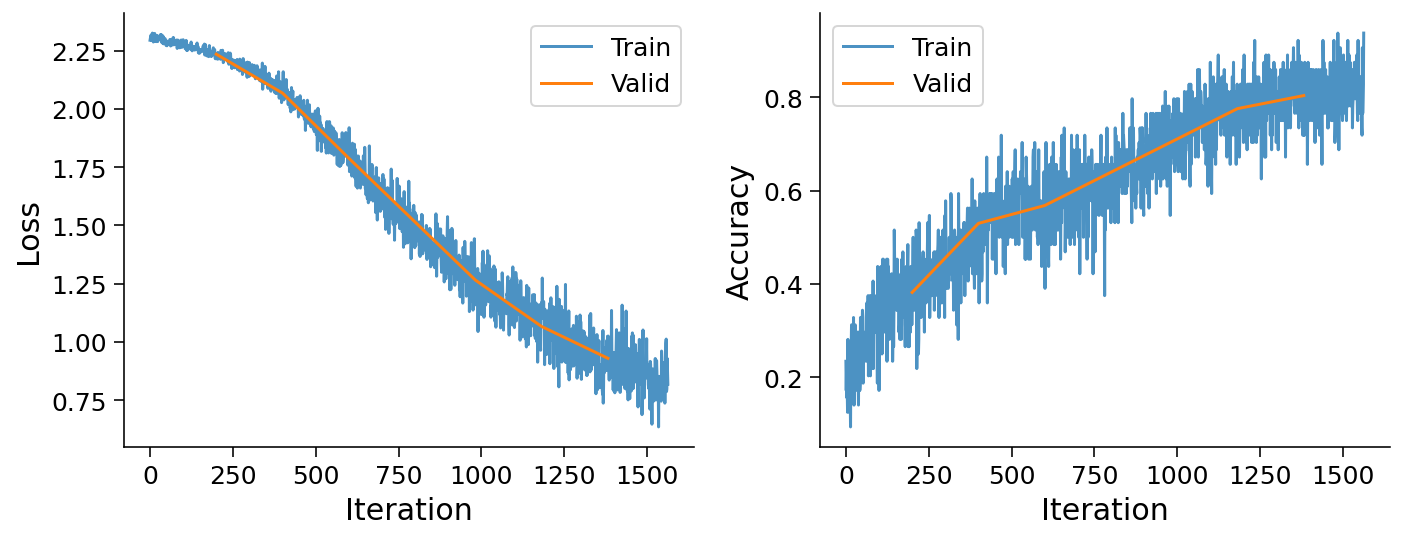

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(range(len(metrics['train_loss'])), metrics['train_loss'],
           alpha=0.8, label='Train')
ax[0].plot(metrics['val_idx'], metrics['val_loss'], label='Valid')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(len(metrics['train_acc'])), metrics['train_acc'],
           alpha=0.8, label='Train')
ax[1].plot(metrics['val_idx'], metrics['val_acc'], label='Valid')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

## Think! Bonus: Metrics

Which metric did you optimize when searching for the right configuration? The training set loss? Accuracy? Validation/test set metrics? Why? Discuss!

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D5_Optimization/solutions/W1D5_Tutorial1_Solution_093a66ad.py)



### Evaluation

We _finally_ can evaluate and compare the performance of the models on previously unseen examples. 

Which model would you keep? (\*drum roll*)    

In [50]:
print('Your model...')
train_loss, train_accuracy = eval_model(my_model, train_loader, device=DEVICE)
test_loss, test_accuracy = eval_model(my_model, test_loader, device=DEVICE)
print(f'Train Loss {train_loss:.3f} / Test Loss {test_loss:.3f}')
print(f'Train Accuracy {100*train_accuracy:.3f}% / Test Accuracy {100*test_accuracy:.3f}%')

print('\nBenchmark model')
train_loss, train_accuracy = eval_model(benchmark_model, train_loader, device=DEVICE)
test_loss, test_accuracy = eval_model(benchmark_model, test_loader, device=DEVICE)
print(f'Train Loss {train_loss:.3f} / Test Loss {test_loss:.3f}')
print(f'Train Accuracy {100*train_accuracy:.3f}% / Test Accuracy {100*test_accuracy:.3f}%')

Your model...
Train Loss 0.826 / Test Loss 0.810
Train Accuracy 82.171% / Test Accuracy 83.252%

Benchmark model
Train Loss 0.011 / Test Loss 0.025
Train Accuracy 99.784% / Test Accuracy 99.316%
